# Quantum Kernel Regression

The tutorial exemplifies how the quantum kernel estimate (QKE) algorithm can be used for regression tasks.

In [1]:
%matplotlib inline

import time
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVR, SVR

# Qiskit
from qiskit import Aer
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit.circuit import QuantumCircuit, ParameterVector, Parameter
from qksvm.QuantumEmbedding import entangle, SingleQubitWall
from qiskit_machine_learning.kernels import QuantumKernel

from qksvm.QKSVR import QKSVR

seed = 12345
np.random.seed(seed)

plt.style.use('classic')
plt.rcParams['font.size'] = 20
plt.rcParams['axes.linewidth'] = 2
plt.rcParams['axes.grid'] = True
plt.rcParams['legend.fontsize'] = 16

In [2]:
def compute_score(y_true, y_pred):
    return {
        "R2": f"{metrics.r2_score(y_true, y_pred):.3f}",
        "MSE": f"{metrics.mean_squared_error(y_true, y_pred):.3f}",
        "MAE": f"{metrics.median_absolute_error(y_true, y_pred):.3f}",
    }

def scores(model, X_train, y_train, X_test, y_test):
    
    y_pred = model.predict(X_train)
    train_scores = compute_score(y_train, y_pred)

    y_pred = model.predict(X_test)
    test_scores = compute_score(y_test, y_pred)
    
    print()
    print(f"R2  scores (train,  test): {train_scores['R2']}  {test_scores['R2']}")
    print(f"MSE scores (train,  test): {train_scores['MSE']}  {test_scores['MSE']}")
    print(f"MAE scores (train,  test): {train_scores['MAE']}  {test_scores['MAE']}")
    print()

In [3]:
def plot_model(model):
    """"""
    plt.figure(figsize=(8, 6), facecolor='w')
    
    plt.scatter(X, y, c="k", s=20, label="data", zorder=1, edgecolors=(0, 0, 0))
    plt.scatter(X_train, y_train, c="r", s=40, marker="s", label="train")
    plt.scatter(X_test,  y_test,  c="b", s=50, marker="^", label="test")

    y_plot = model.predict(X_plot)

    plt.plot(
        X_plot,
        y_plot,
        c="g",
        lw=4,
        label="SVR",
    )
    plt.xlabel("data")
    plt.ylabel("target")
    _ = plt.legend()

## Dataset

We consider the simplest example for 1d regression -- the "noisy sinus" function. The input data points for representing our target function are computed by applying the random Gaussian shifts to some values of $y = \mathrm{sin}(x)$ computed on a grid within the function period $x \in [0, 2\pi]$.

In [4]:
rng = np.random.RandomState(42)

X = 2*np.pi * rng.rand(100, 1)
y = np.sin(X).ravel()

# Add noise to targets
y[::5] += 3 * (0.5 - rng.rand(X.shape[0] // 5))

X_plot = np.linspace(0, 2*np.pi, 100)[:, None]

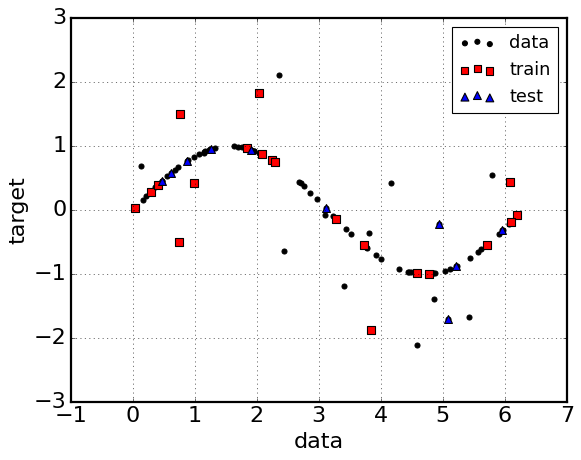

In [5]:
train_size = 20
test_size = 10

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    train_size=train_size, test_size=test_size,
    random_state=100
)

plt.figure(figsize=(8, 6), facecolor='w')
plt.scatter(X, y, c="k", s=20, label="data", zorder=1, edgecolors=(0, 0, 0))
plt.scatter(X_train, y_train, c="r", s=40, marker="s", label="train")
plt.scatter(X_test,  y_test,  c="b", s=50, marker="^", label="test")

plt.xlabel("data")
plt.ylabel("target")
plt.legend()
plt.show()

# SVR

To get a classical reference, we execute first the Scikit-Learn's support vector regressor [SVR](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html) with the RBF kernel. Following the standard approach, we tune the SVR hyperparameters using the CV grid search.

Best SVR with params: {'C': 20, 'gamma': 0.12328467394420659} and R2 score: 0.178

R2  scores (train,  test): 0.708  0.813
MSE scores (train,  test): 0.221  0.125
MAE scores (train,  test): 0.100  0.105



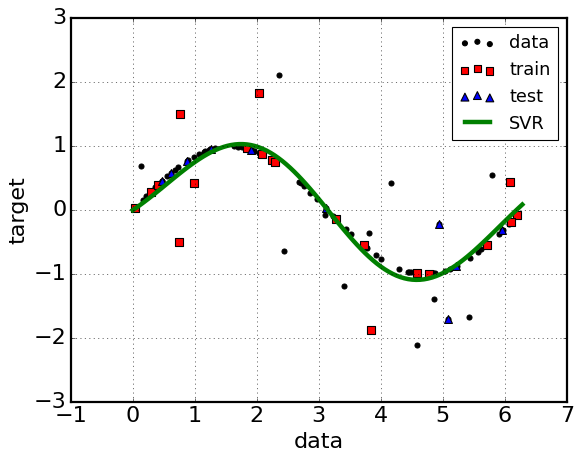

In [6]:
svr = GridSearchCV(
    SVR(kernel="rbf"),
    param_grid={"C": [1, 5, 10, 15, 20,], "gamma": np.logspace(-2, 1, 100)},
    scoring='r2',
    n_jobs=1,
    cv=KFold(n_splits=2, shuffle=True, random_state=seed),
)
svr.fit(X_train, y_train)
print(f"Best SVR with params: {svr.best_params_} and R2 score: {svr.best_score_:.3f}")

scores(svr, X_train, y_train, X_test, y_test)
plot_model(svr)

# QKSVR

The class QKSVR is an extension of the Scikit-Learn SVR class to support the quantum kernels.
The user should provide the quantum feature map (e. g., implicitly as shown below).
In the example below we use the simplest 1 qubit circuit with the input data encoded with the Pauli RX gate.

   ┌──────────────┐ ░ 
q: ┤ Rx(1.0*x[0]) ├─░─
   └──────────────┘ ░ 

R2  scores (train,  test): 0.657  0.817
MSE scores (train,  test): 0.260  0.122
MAE scores (train,  test): 0.098  0.075

Timing info: 00h00m00s


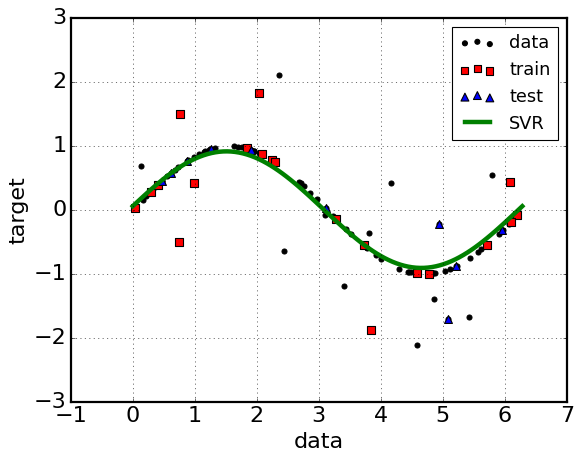

In [7]:
t0 = time.perf_counter()

qksvr = QKSVR(
    n_qubits=len(X[0]),
    feature_map=['rx'], 
    alpha=1.0, C=1, 
    random_state=seed
)
qksvr.fit(X_train, y_train)

# to visualize the implicitly constructed quantum circuit
print(qksvr.fm.draw())

scores(qksvr, X_train, y_train, X_test, y_test)
plot_model(qksvr)

t1 = time.perf_counter()
print( 'Timing info:', time.strftime("%Hh%Mm%Ss", time.gmtime(t1-t0)) )

## GridSearchCV

In general case, one should perform the quantum kernel hyperparameter search similarly we did for the classical RBF kernel.

Best SVR with params: {'C': 100, 'alpha': 0.5, 'feature_map': ['rx', 'cx'], 'n_layers': 2, 'n_qubits': 1} and R2 score: 0.436

R2  scores (train,  test): 0.679  0.814
MSE scores (train,  test): 0.244  0.125
MAE scores (train,  test): 0.091  0.108



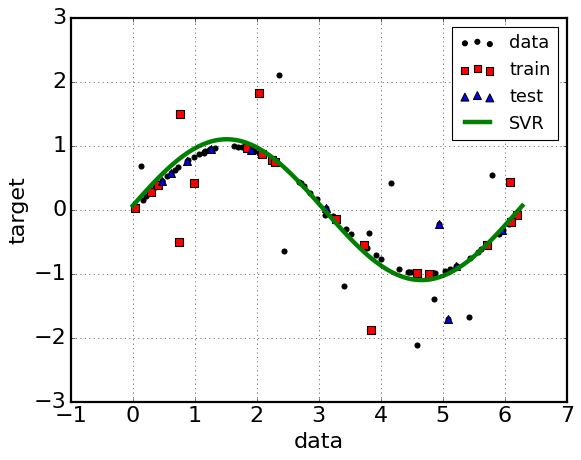

In [8]:
param_grid = {
    "n_qubits": [1, 2, ],
    "n_layers": [1, 2, ],
    "alpha": [0.25, 0.5, 1.0, 1.5],
    "C": [1, 10, 100],
    "feature_map": [
        ['rx', 'cx'],
        ['rx', 'cz'],
        ['rx', 'swap'],
        ['rx', 'iswap'],
        ['rx', 'ry'],
        ['rx', 'crz'],
    ]
}

svr = GridSearchCV(
    QKSVR(entanglement='linear', random_state=seed),
    param_grid=param_grid,
    scoring='r2',
    n_jobs=1,
    cv=KFold(n_splits=2, shuffle=True, random_state=seed),
)
svr.fit(X_train, y_train)
print(f"Best SVR with params: {svr.best_params_} and R2 score: {svr.best_score_:.3f}")

scores(svr, X_train, y_train, X_test, y_test)
plot_model(svr)

The CV search returned a single qubit RX model with two layers, $\alpha=0.5$, and $C=100$.
What about other top-ranked models?

In [9]:
idx = np.argsort(svr.cv_results_['mean_test_score'])

print("\nBest solutions:\n")
for i in range(10):
    print(f"rank={abs(-i-1)}, score={svr.cv_results_['mean_test_score'][idx[-i-1]]:.2f}, ", "params = ", svr.cv_results_['params'][idx[-i-1]])


Best solutions:

rank=1, score=0.44,  params =  {'C': 100, 'alpha': 0.5, 'feature_map': ['rx', 'cx'], 'n_layers': 2, 'n_qubits': 1}
rank=2, score=0.44,  params =  {'C': 100, 'alpha': 0.5, 'feature_map': ['rx', 'iswap'], 'n_layers': 2, 'n_qubits': 1}
rank=3, score=0.44,  params =  {'C': 100, 'alpha': 0.5, 'feature_map': ['rx', 'crz'], 'n_layers': 2, 'n_qubits': 1}
rank=4, score=0.44,  params =  {'C': 100, 'alpha': 0.5, 'feature_map': ['rx', 'cz'], 'n_layers': 2, 'n_qubits': 1}
rank=5, score=0.44,  params =  {'C': 100, 'alpha': 0.5, 'feature_map': ['rx', 'swap'], 'n_layers': 2, 'n_qubits': 1}
rank=6, score=0.44,  params =  {'C': 100, 'alpha': 1.0, 'feature_map': ['rx', 'swap'], 'n_layers': 1, 'n_qubits': 1}
rank=7, score=0.44,  params =  {'C': 100, 'alpha': 1.0, 'feature_map': ['rx', 'iswap'], 'n_layers': 1, 'n_qubits': 1}
rank=8, score=0.44,  params =  {'C': 100, 'alpha': 1.0, 'feature_map': ['rx', 'cz'], 'n_layers': 1, 'n_qubits': 1}
rank=9, score=0.44,  params =  {'C': 100, 'alpha': 

The top-10 CV models prefer 1-qubit feature maps and $C=100$. We should also take into account that for 1-qubit case all two-qubit operators (such as CX, etc.) make no sense and therefore ignored by the algorithm. 
This means that the model we have used above is also in the list and has the same score as the two-layer model.

To perform the regression and visualize results for a specific CV model, one could execute

     ┌──────────────┐ ░                 ┌──────────────┐ ░ ┌──────────────┐ ░ »
q_0: ┤ Rx(0.5*x[0]) ├─░────────■────────┤ Rz(0.5*x[0]) ├─░─┤ Rx(0.5*x[0]) ├─░─»
     ├──────────────┤ ░ ┌──────┴───────┐└──────┬───────┘ ░ ├──────────────┤ ░ »
q_1: ┤ Rx(0.5*x[0]) ├─░─┤ Rz(0.5*x[0]) ├───────■─────────░─┤ Rx(0.5*x[0]) ├─░─»
     └──────────────┘ ░ └──────────────┘                 ░ └──────────────┘ ░ »
«                     ┌──────────────┐ ░ 
«q_0: ───────■────────┤ Rz(0.5*x[0]) ├─░─
«     ┌──────┴───────┐└──────┬───────┘ ░ 
«q_1: ┤ Rz(0.5*x[0]) ├───────■─────────░─
«     └──────────────┘                 ░ 

R2  scores (train,  test): 0.706  0.790
MSE scores (train,  test): 0.223  0.141
MAE scores (train,  test): 0.100  0.169



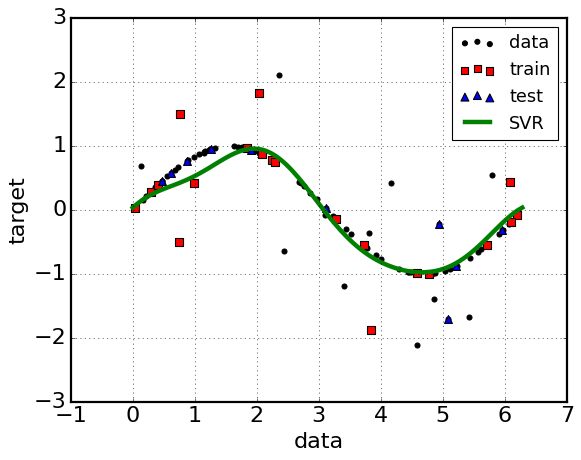

In [10]:
params = {'C': 100, 'alpha': 0.5, 'feature_map': ['rx', 'crz'], 'n_layers': 2, 'n_qubits': 2}

qksvr = QKSVR(
    C=params['C'],
    alpha=params['alpha'],
    feature_map=params['feature_map'],
    n_layers=params['n_layers'],
    n_qubits=params['n_qubits'],
    entanglement='ring', 
    random_state=seed)
qksvr.fit(X_train, y_train)

# to visualize the implicitly constructed quantum circuit
print(qksvr.fm.draw())

scores(qksvr, X_train, y_train, X_test, y_test)
plot_model(qksvr)